# Contents of this Notebook
• Quick look at some images in the dataset

• Download a few categories of shape positives and some categories to distinguish those from

• Download the classification text file

• Set some core variables needed throughout

• Load flattened arrays (N, 784) → reshape to (N, 28, 28)

• Organise data into X and y

• Define and compile the model

• Test train split

• Training

• Preview, graphs, refinement

• Saving the model and converting it into a javascript model (tensorflowjs) via terminal commands



In [12]:
from quickdraw import QuickDrawDataGroup
from IPython.display import display
import os, urllib.request
import requests
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import json, pathlib
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

In [63]:
DATA_DIR = "data"  # where your .npy files are

TARGETS = [
    "circle",
    "square",
    "triangle",
    "star",
    "vertical_line",
    "vertical_arrows",
    "axis",
    "bat",
    "car",
    "cat",
    "eyeglasses",
    "face",
    "hat",
    "microphone",
    "moon",
    "sailboat"
    ]
OTHERS = ["house", "tree", "zigzag", "hockey%20stick", "arm", "cloud", "hexagon", "paint%20can"]

CLASS_NAMES = TARGETS #+ ["other"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}

classes = TARGETS #+ OTHERS

In [62]:
CLASS_NAMES

['circle',
 'square',
 'triangle',
 'star',
 'vertical_line',
 'vertical_arrows',
 'axis',
 'bat',
 'car',
 'cat',
 'eyeglasses',
 'face',
 'hat',
 'microphone',
 'moon',
 'sailboat',
 'other']

In [20]:

os.makedirs(DATA_DIR, exist_ok=True) #make the data directory if you don't have it on your machine

base = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"

for c in classes:
    url = f"{base}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")
    if not os.path.exists(dst):
        print("downloading", url)
        urllib.request.urlretrieve(url, dst)
print("done")

downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/microphone.npy
downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/moon.npy
downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sailboat.npy
downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hexagon.npy
downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/paint%20can.npy
done


# 1. About the data - What Google did with QuickDraw

Each QuickDraw doodle was drawn by a person as a sequence of strokes (vector data).

Google rasterised those strokes into 28 × 28 pixel images, grayscale.

Each pixel is **grayscale** — it holds an intensity value from 0 to 255 (0 = black, 255 = white, or sometimes inverted depending on convention).

To make the dataset compact, they then flattened each 28×28 image into a 1D vector of length 784 (because 28 × 28 = 784).

In [21]:
def load_npy(path, limit=None):
    """
    Quick, Draw! numpy_bitmap .npy: shape (N, 784) uint8.
    Returns (N, 28, 28) uint8.
    """
    arr = np.load(path)                 # (N, 784) uint8
    if limit is not None:
        arr = arr[:limit]
    return arr.reshape(-1, 28, 28)      # -> (N,28,28)

# Logic of the data distribution in the model
Some false positive classes were included to train the model - it needs to learn not only to recognise circles and squares but also to disregard random stuff. The random stuff included in this model is:

 "face", "cat", "cloud", "house", "tree"

 But this could be increased to make a better model.

 Below the function therefore deals with both of those.


# What the function returns

X: all images, normalised to [0,1] and shaped (N, 28, 28, 1) (float32).

y: one integer label per image, shaped (N,) (int64). Uses your CLASS_TO_ID mapping.

In [22]:
def build_arrays(data_dir, per_class=8000, other_total=5000, seed=0):
    rng = np.random.default_rng(seed)  # for a reproducible final shuffle

    Xs, ys = [], []  # we collect per-class arrays here (features X, labels y)

    # 1) TARGET classes: circle/square/triangle/star
    for cname in TARGETS:
        Xc = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_class)
        # Xc: (per_class, 28, 28) uint8 — the images for this target class
        yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
        # yc: (per_class,) int64 — the labels for this class, all the same id
        Xs.append(Xc)
        ys.append(yc)

    # 2) "OTHER" bucket: pool several categories into one label
    per_other = max(1, other_total // len(OTHERS))  # try to sample evenly
    other_parts = []
    for cname in OTHERS:
        Xo_part = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_other)
        other_parts.append(Xo_part)
    Xo = np.concatenate(other_parts, axis=0)             # (~other_total, 28, 28)
    yo = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)  # same id for all


    # 3) Concatenate everything into single feature/label arrays
    X = np.concatenate(Xs + [Xo], axis=0)  # (N, 28, 28) uint8
    y = np.concatenate(ys + [yo], axis=0)  # (N,)        int64

    # 4) Normalise & add channel dim for Keras (channels-last)
    X = (X.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1) float32

    # 5) Final shuffle to mix classes so batches aren’t blocky
    idx = rng.permutation(len(X))
    return X[idx], y[idx]


In [24]:
X, y = build_arrays(DATA_DIR, per_class=5000, other_total=5000)  # ~15k total
X.shape, y.shape, np.bincount(y)
# Expect: ((~15000, 28, 28, 1), (~15000,), counts per class)

((80511, 28, 28, 1),
 (80511,),
 array([5000, 5000, 5000, 5000, 5000, 5000,  511, 5000, 5000, 5000, 5000,
        5000, 5000, 5000, 5000, 5000, 5000]))

In [25]:
def build_vertical_arrows(data_dir, max_samples=500, rotations_per_img=20, seed=0):
    rng = np.random.default_rng(seed)

    # Load the base vertical arrows
    path = os.path.join(data_dir, "vertical_arrows.npy")
    X_base = load_npy(path)

    # Subsample if too many
    if len(X_base) > max_samples:
        X_base = rng.choice(X_base, size=max_samples, replace=False)

    # Augment with rotations
    Xs, yos = [], []
    angles = np.linspace(0, 360, rotations_per_img, endpoint=False)
    for img in X_base:
        for angle in angles:
            Xs.append(rotate(img, angle, reshape=False, order=1, mode='constant'))
            yos.append(angle)

    # Convert to arrays
    X = np.array(Xs)[..., None].astype("float32") / 255.0  # (N,28,28,1)
    yo_rad = np.deg2rad(np.array(yos))
    y_orient = np.stack([np.sin(yo_rad), np.cos(yo_rad)], axis=1)  # (N,2)

    # Shuffle
    idx = rng.permutation(len(X))
    return X[idx], y_orient[idx]

# Example usage
X_arr, y_arr_orient = build_vertical_arrows(DATA_DIR)
print(X_arr.shape, y_arr_orient.shape)

(10000, 28, 28, 1) (10000, 2)


In [ ]:
'''
def make_preprocess():
  preprocess = tf.keras.Sequential([
    keras.layers.RandomBrightness(factor=0.4),
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.8),
  ])

  return preprocess

def make_model1():
  model = keras.Sequential([
    keras.Input(shape=(225, 225, 3)),
    keras.layers.Conv2D(6, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(4, kernel_size=(3), activation='relu'), # kernel_size = 3 <==> (3, 3)
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

def make_model2():
  model = keras.Sequential([
    keras.Input(shape=(225, 225, 3)),
    keras.layers.Conv2D(6, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(4, kernel_size=(3), activation='relu'), # kernel_size = 3 <==> (3, 3)
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

def make_combined_model():
  model1 = make_model1()
  model2 = make_model2()

  input_layer = keras.Input(shape=(225, 225, 3)) # your input layer
  output1 = model1(input_layer)
  output2 = model2(input_layer)

  model = keras.Model(inputs=input_layer, outputs=[output1, output2])
  return model1, model2, model

def make_combined_model_with_preprocessor():
  preprocess = make_preprocess()
  model1, model2, model_nopreprocess = make_combined_model()

  full_model = keras.Sequential([
    keras.Input(shape=(225, 225, 3)),
    preprocess,
    model_nopreprocess
  ])

  return model1, model2, preprocess, model_nopreprocess, full_model

_, _, _, model_nopreprocess, full_model = make_combined_model_with_preprocessor()

full_model.compile() # might need some args
full_model.fit(X,y)

# save the part of the model AFTER data agumentation pipeline
model_nopreprocess.save() # might need some args

'''


In [ ]:
# def make_preprocess():
#   preprocess = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.15, fill_mode="constant", fill_value=0.0)
#   ])
#   return preprocess

In [28]:
def initialize_model():
    n_classes = len(CLASS_NAMES) # all classes except vertical_arrows

    # 1) the clean model (this is the one you’ll export / use later)
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(2),                  # 28→14
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(2),                  # 14→7
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ], name="classifier")
    ''' commented out use of data augmentation pipeline due to complications with tldraw'''
    # # 2) augmentation pipeline
    # data_augmentation = models.Sequential([
    #     layers.RandomFlip("horizontal_and_vertical"),
    #     layers.RandomRotation(0.15, fill_mode="constant", fill_value=0.0),
    # ], name="aug")
    # 3) training model = aug + model
    train_model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        #data_augmentation
        model
    ], name="train_model")

    train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

    train_model.summary()

    return train_model


In [29]:
classification_model = initialize_model()

Model: "train_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier (Sequential)     (None, 17)                106321    
                                                                 
Total params: 106321 (415.32 KB)
Trainable params: 106321 (415.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.3, random_state=39, stratify=y)

es = EarlyStopping(patience=5, restore_best_weights=True)

# 4) fit with train_model
history = classification_model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=50, batch_size=256, verbose=1, callbacks=[es]
)

# # 5) when exporting: save only the clean classifier
# model.save("shapes_tinycnn_keras.h5")

Epoch 1/50
221/221 [==============================] - 20s 83ms/step - loss: 1.1418 - accuracy: 0.6515 - val_loss: 0.7912 - val_accuracy: 0.7340
Epoch 2/50
221/221 [==============================] - 18s 81ms/step - loss: 0.6985 - accuracy: 0.7622 - val_loss: 0.6262 - val_accuracy: 0.7827
Epoch 3/50
221/221 [==============================] - 18s 80ms/step - loss: 0.6103 - accuracy: 0.7898 - val_loss: 0.5824 - val_accuracy: 0.7963
Epoch 4/50
221/221 [==============================] - 19s 84ms/step - loss: 0.5620 - accuracy: 0.8037 - val_loss: 0.5619 - val_accuracy: 0.8033
Epoch 5/50
221/221 [==============================] - 19s 84ms/step - loss: 0.5299 - accuracy: 0.8136 - val_loss: 0.5394 - val_accuracy: 0.8103
Epoch 6/50
221/221 [==============================] - 19s 84ms/step - loss: 0.5071 - accuracy: 0.8214 - val_loss: 0.5292 - val_accuracy: 0.8116
Epoch 7/50
221/221 [==============================] - 19s 85ms/step - loss: 0.4865 - accuracy: 0.8266 - val_loss: 0.5222 - val_accuracy:

In [51]:
classification_model

In [31]:
def angular_loss(y_true, y_pred):
    # normalize
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    # cosine similarity = cos(θ_error)
    cos_sim = tf.reduce_sum(y_true * y_pred, axis=-1)
    return 1 - cos_sim  # smaller is better


def initialize_orientation_model(input_shape=(28, 28, 1), model=None):
    '''
        if model:
            load the model from .h5

        else:
            define model architecture
            fit

    '''
    model = models.Sequential([
        # Feature extractor
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.Flatten(),

        # Dense regression head
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),

        # Output: (sin, cos)
        layers.Dense(2, activation="linear")
    ])

    # Compile with angular loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=angular_loss,
        metrics=["mae"]
    )

    return model

In [33]:
def show_image(img, y):
    """
    Display a (28, 28, 1) numpy matrix as a grayscale image.
    """
    if img.shape == (28, 28, 1):
        img = img.squeeze()  # remove the channel dimension -> (28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(y, fontsize=9)
    plt.axis('off')
    plt.show()

In [37]:
len(X)

80511

In [44]:
rand_index = np.random.randint(0, len(X))

In [45]:
rand_index

55051

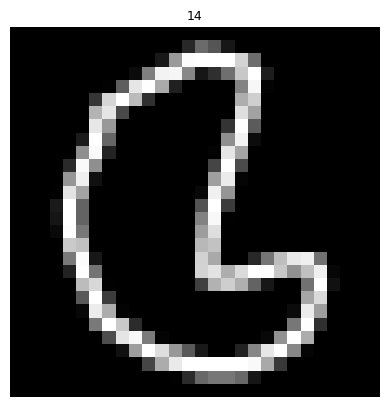

In [46]:
show_image(X[rand_index], y[rand_index])

In [112]:
orientation_model = initialize_orientation_model()

In [ ]:
# conditionally fit the model based on whether we loaded it in from a file or newly initialized

Xa_tr, Xa_va, ya_tr, ya_va = train_test_split(X_arr, y_arr_orient, test_size=0.3, random_state=39

es = EarlyStopping(patience=5, restore_best_weights=True)

# 4) fit with train_model
history_2 = orientation_model.fit(
    Xa_tr, ya_tr,
    validation_data=(Xa_va, ya_va),
    epochs=50, batch_size=256, verbose=1, callbacks=[es]
)

Epoch 1/50
28/28 [==============================] - 6s 124ms/step - loss: 1.0127 - mae: 0.6400 - val_loss: 0.9767 - val_mae: 0.6423
Epoch 2/50
28/28 [==============================] - 4s 128ms/step - loss: 1.0083 - mae: 0.6500 - val_loss: 0.9852 - val_mae: 0.6458
Epoch 3/50
28/28 [==============================] - 4s 134ms/step - loss: 1.0038 - mae: 0.6486 - val_loss: 1.0060 - val_mae: 0.6429
Epoch 4/50
28/28 [==============================] - 4s 155ms/step - loss: 0.9775 - mae: 0.6374 - val_loss: 0.9768 - val_mae: 0.6306
Epoch 5/50
28/28 [==============================] - 4s 148ms/step - loss: 0.3289 - mae: 0.6093 - val_loss: 0.1148 - val_mae: 0.5869
Epoch 6/50
28/28 [==============================] - 4s 127ms/step - loss: 0.0772 - mae: 0.5845 - val_loss: 0.0424 - val_mae: 0.5848
Epoch 7/50
28/28 [==============================] - 3s 122ms/step - loss: 0.0343 - mae: 0.5892 - val_loss: 0.0133 - val_mae: 0.5935
Epoch 8/50
28/28 [==============================] - 3s 117ms/step - loss: 0.

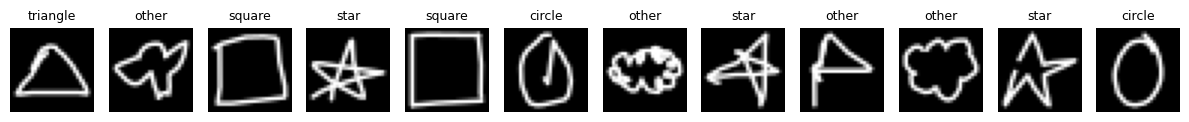

In [ ]:
def show_grid(X, y, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(X[i,...,0], cmap="gray")
        plt.title(CLASS_NAMES[y[i]], fontsize=9)
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_grid(Xtr, ytr, n=12)


              precision    recall  f1-score   support

      circle      0.979     0.917     0.947       300
      square      0.958     0.913     0.935       300
    triangle      0.941     0.960     0.950       300
        star      0.955     0.913     0.934       300
       other      0.818     0.927     0.869       300

    accuracy                          0.926      1500
   macro avg      0.930     0.926     0.927      1500
weighted avg      0.930     0.926     0.927      1500



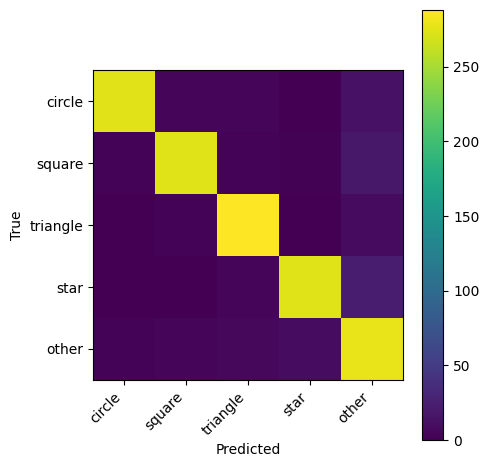

In [27]:
# predictions on validation set
proba = model.predict(Xva, verbose=0)
yhat  = proba.argmax(axis=1)

print(classification_report(yva, yhat, target_names=CLASS_NAMES, digits=3))

# confusion matrix (vanilla matplotlib)
cm = confusion_matrix(yva, yhat, labels=range(len(CLASS_NAMES)))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(CLASS_NAMES))); ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


In [28]:
# pick a few that weren't in TARGETS or OTHERS
UNSEEN = ["airplane","banana","bus","chair"]
unseen_batch = []
for c in UNSEEN:
    path = os.path.join(DATA_DIR, f"{c}.npy")
    if os.path.exists(path):
        arr = np.load(path)[:200].reshape(-1,28,28,1).astype("float32")/255.0
        unseen_batch.append(arr)
if unseen_batch:
    X_unseen = np.concatenate(unseen_batch, axis=0)
    labels, maxp, _ = predict_with_reject(X_unseen, tau=0.6)
    unknown_rate = (labels==-1).mean()
    print(f"Unknown rate on unseen classes: {unknown_rate:.2%} (want this fairly high)")

In [29]:

def predict_one(img28, tau=0.6, mdl=model, classes=CLASS_NAMES):
    x = img28.astype("float32")
    if x.max() > 1.0:
        x = x / 255.0
    x = x[None, ..., None]
    proba = mdl.predict(x, verbose=0)[0]
    i = proba.argmax()
    return ("unknown", float(proba[i])) if proba[i] < tau else (classes[i], float(proba[i]))


# demo on a val sample
lbl, conf = predict_one((Xva[0,...,0]*255).astype("uint8"), tau=0.6)
lbl, conf, "true:", CLASS_NAMES[yva[0]]

('star', 0.6342745423316956, 'true:', 'star')

In [30]:
# jitter the training images by ±1 pixel
def jitter_shift(x):
    dy = np.random.randint(-1, 2)
    dx = np.random.randint(-1, 2)
    return np.roll(np.roll(x, dy, axis=0), dx, axis=1)

aug_X = Xtr.copy()
mask = np.random.rand(len(aug_X)) < 0.5
aug_X[mask,...,0] = np.array([jitter_shift(im) for im in aug_X[mask,...,0]])

history = train_model.fit(aug_X, ytr, validation_data=(Xva, yva),
                    epochs=3, batch_size=256, verbose=1)


Epoch 1/3
53/53 [==============================] - 1s 23ms/step - loss: 0.2418 - accuracy: 0.9256 - val_loss: 0.2227 - val_accuracy: 0.9333
Epoch 2/3
53/53 [==============================] - 1s 22ms/step - loss: 0.2366 - accuracy: 0.9236 - val_loss: 0.2269 - val_accuracy: 0.9247
Epoch 3/3
53/53 [==============================] - 1s 21ms/step - loss: 0.2290 - accuracy: 0.9283 - val_loss: 0.2156 - val_accuracy: 0.9353


In [59]:
classification_model.save("new_model.h5")

/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
#  Now go to terminal to make a js model
#
#  tensorflowjs_converter --input_format=keras \
#  notebooks/louise_notebooks/shapes_tinycnn_keras.h5 \
#  web_model/

In [117]:
orientation_model.save("model_orientation.h5")

/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [118]:
classification_model.save("model_classification.h5")

In [60]:
#  Now go to terminal to make a js model
!tensorflowjs_converter --input_format=keras \
    new_model.h5 \
    web_model/

In [122]:
#  Now go to terminal to make a js model
!tensorflowjs_converter --input_format=keras \
    model_classification.h5 \
    web_model/

In [15]:
# --- Section 7: Prediction utility ---
def predict_and_show_rotated(img_rotated, class_names=CLASS_NAMES):
    img_input = img_rotated
    img_input = np.expand_dims(img_input, axis=0)

    class_pred = classification_model.predict(img_input, verbose=0)
    orient_pred = orientation_model.predict(img_input, verbose=0)

    pred_class_idx = np.argmax(class_pred, axis=1)[0]
    pred_class_name = class_names[pred_class_idx]
    sin_pred, cos_pred = orient_pred[0]

    # normalize sin/cos
    norm = np.sqrt(sin_pred**2 + cos_pred**2)
    sin_pred /= norm
    cos_pred /= norm

    # predicted orientation in degrees
    pred_orientation = np.rad2deg(np.arctan2(sin_pred, cos_pred)) % 360

    plt.imshow(img_rotated, cmap='gray')
    plt.axis('off')
    plt.title(f"{pred_class_name}\nPredicted orientation: {pred_orientation:.1f}°")

    # --- Arrow drawing ---
    center = (14, 14)
    length = 10

    # Rotate angle so that 0° = up, 90° = left
    angle_rad = np.deg2rad(pred_orientation)
    dx = -length * np.sin(angle_rad)   # X component
    dy = -length * np.cos(angle_rad)   # Y component (negative because image coords)

    plt.arrow(center[0], center[1], dx, dy,
              color='red', head_width=2, head_length=3)
    plt.show()

    return pred_class_name, pred_orientation

In [10]:
from scipy.ndimage import rotate

def prep_image(n):


    # Load vertical_arrows class
    arr = np.load("data/axis.npy")  # shape (N, 784)

    # Pick the 4th sample (index 3)
    img_flat = arr[n]

    # Choose a random rotation angle (0–360 degrees)
    angle = np.random.uniform(0, 360)


    # Rotate the image
    return rotate(img_flat.reshape(28,28), angle, reshape=False, order=1, mode='constant')

In [ ]:
# Load vertical_arrows class
arr = np.load("data/cat.npy")  # shape (N, 784)

# Pick the 4th sample (index 3)
img_flat = arr[66]

# Choose a random rotation angle (0–360 degrees)
angle = np.random.uniform(0, 360)


# Rotate the image
img_rotated = rotate(img_flat.reshape(28,28), angle, reshape=False, order=1, mode='constant')

In [ ]:
# Manual tests:

img_input = img_flat.reshape(28,28)
img_input = np.expand_dims(img_input, axis=0)

class_pred = classification_model.predict(img_input)
pred_class_idx = np.argmax(class_pred, axis=1)[0]
pred_class_name = CLASS_NAMES[pred_class_idx]


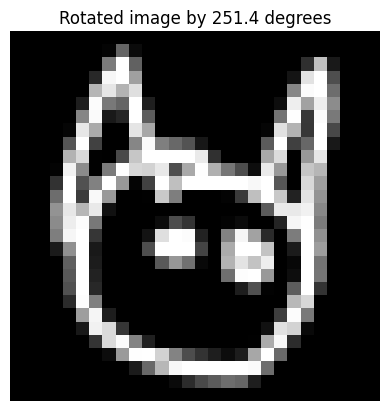

Rotation angle: 251.44678804894582


In [52]:
plt.imshow(img_flat.reshape(28,28), cmap='gray')
plt.title(f"Rotated image by {angle:.1f} degrees")
plt.axis('off')
plt.show()

print("Rotation angle:", angle)

In [ ]:
rotate(img_flat.reshape(28,28), angle, reshape=False, order=1, mode='constant')

In [50]:
pred_class, pred_orient = predict_and_show_rotated(prep_image(X[4100]))

NameError: name 'predict_and_show_rotated' is not defined

In [61]:
CLASS_NAMES

['circle',
 'square',
 'triangle',
 'star',
 'vertical_line',
 'vertical_arrows',
 'axis',
 'bat',
 'car',
 'cat',
 'eyeglasses',
 'face',
 'hat',
 'microphone',
 'moon',
 'sailboat',
 'other']

In [17]:
pred_class, pred_orient = predict_and_show_rotated(arr[66])

NameError: name 'classification_model' is not defined